In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 3
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)
source_scaling = config["source_scaling"]

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/',['no_sub_noise'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
s_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["s_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
phy_loss = models.LensingLoss(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG,device=device,alpha=alpha, resolution=resolution, BATCH_SIZE=BATCH_SIZE, source_scaling=source_scaling).to(device)

opt = torch.optim.Adam(params=list(s_model.parameters())+list(i_model.parameters()),lr=LR)
total_params = sum(p.numel() for p in s_model.parameters())
print(f"Number of parameters: {total_params}x2")

Number of parameters: 899843x2


In [6]:
def give_random_image(dataset, model1, model2, length, i = None):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    t1 = model1(t.float().to(device)).cpu().detach()
    t2 = model2(t.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3, image4 = phy_loss.get_samples(t1.to(device))
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2, Image.fromarray(image3.cpu().numpy()[0][0]*255), Image.fromarray(image4.cpu().numpy()[0][0]*255))

def show_random_image(image_tuple):
    image0, image1, image2, image3, image4 = image_tuple[0], image_tuple[1], image_tuple[2], image_tuple[3], image_tuple[4]
    plot, axes = plt.subplots(1,5)
    plot.set_size_inches(30,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[3].imshow(image3)
    axes[4].imshow(image4)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Source_network")
    axes[3].set_title("Source_regenerated")
    axes[4].set_title("Source_true")

In [7]:
i_model.load_state_dict(torch.load('bicubic.pt'))
s_model.load_state_dict(torch.load('s_weight.pt'))

<All keys matched successfully>

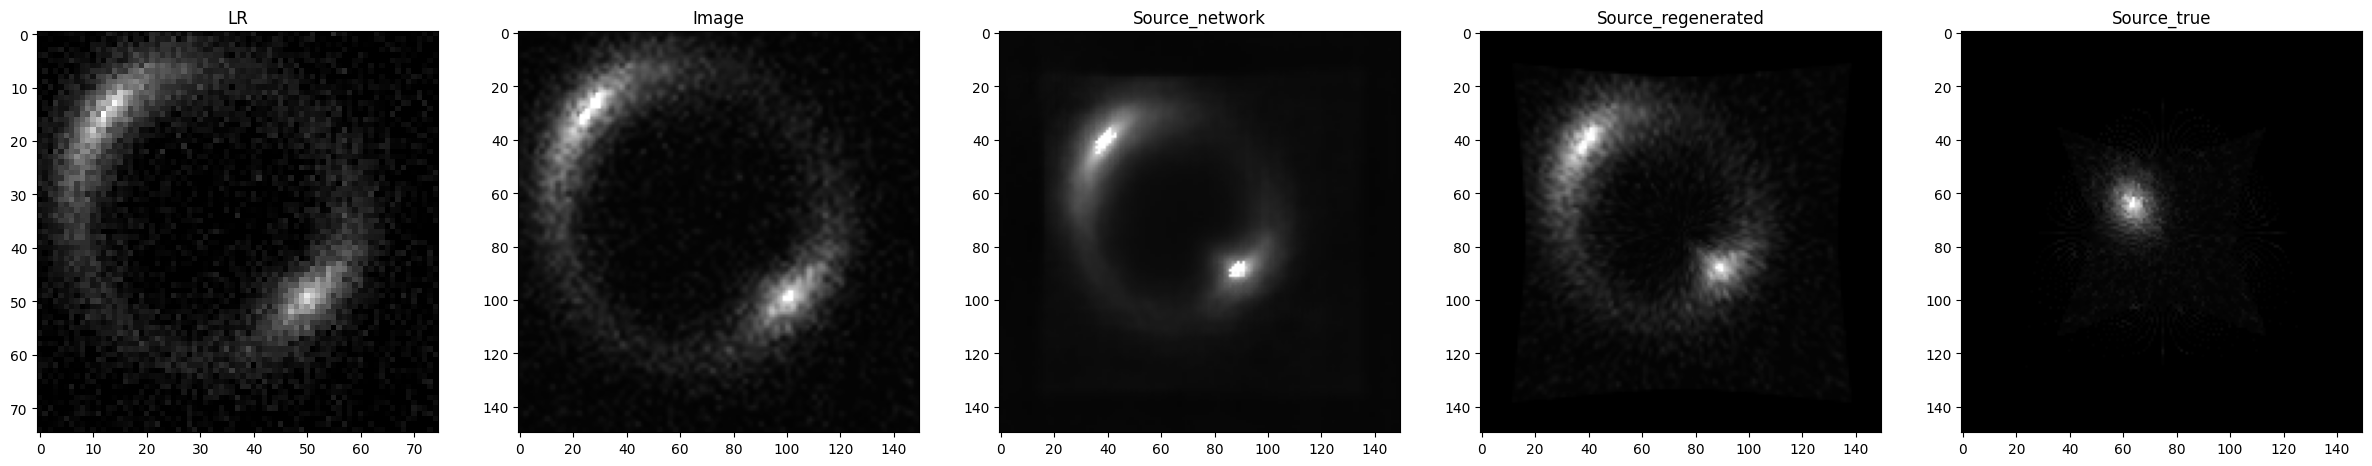

In [8]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))

In [9]:
best_val_loss = np.inf
best_i_weights = None
best_s_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'sources':[], 'lr':[], 'true_source':[]}
for epoch in range(EPOCHS):
    losses = []
    i_model.train()
    s_model.train()
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        loss = phy_loss(source, image, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    i_model.eval()
    s_model.eval()
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        # k_tensor = k_model(x)
        val_loss = phy_loss(source, image, x)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_i_weights = i_model.state_dict()
        best_s_weights = s_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr, _, st = give_random_image(val_dataset, i_model, s_model, len(val_dataset),50)
    history['lr'].append(lr)
    history['images'].append(im)
    history['sources'].append(sr)
    history['true_source'].append(st)

Training epoch 1: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 1/3: 0.0007150971997907618 at LR=0.0001


Validation epoch 1: 100%|██████████| 200/200 [00:06<00:00, 33.28it/s]


Validation at epoch 1/3: 0.000619109554681927 at LR=0.0001


Training epoch 2: 100%|██████████| 800/800 [01:07<00:00, 11.88it/s]


Training at epoch 2/3: 0.0006250930697569856 at LR=0.0001


Validation epoch 2: 100%|██████████| 200/200 [00:06<00:00, 33.01it/s]


Validation at epoch 2/3: 0.000579091494291788 at LR=0.0001


Training epoch 3: 100%|██████████| 800/800 [01:07<00:00, 11.86it/s]


Training at epoch 3/3: 0.0005935043839781429 at LR=0.0001


Validation epoch 3: 100%|██████████| 200/200 [00:06<00:00, 32.84it/s]

Validation at epoch 3/3: 0.0005699271215416957 at LR=0.0001


In [10]:
s_model.load_state_dict(best_s_weights)
i_model.load_state_dict(best_i_weights)
torch.save(s_model.state_dict(),'s_weight_sis_noise.pt')
torch.save(i_model.state_dict(),'i_weight_sis_noise.pt')

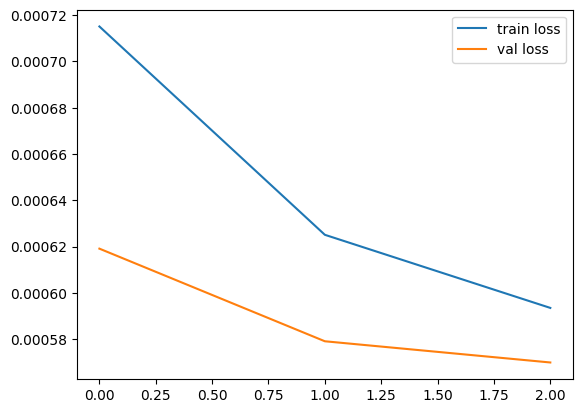

In [11]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.legend()

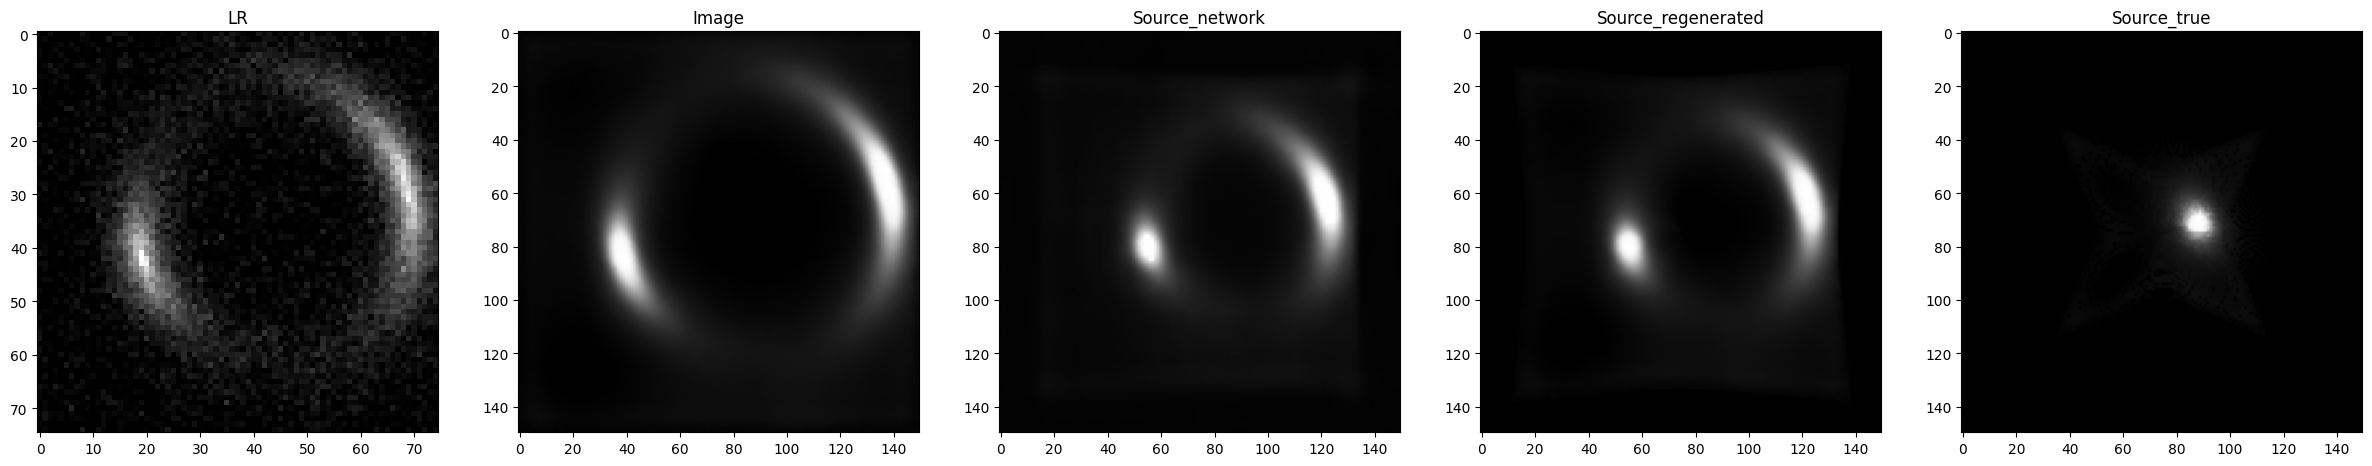

In [14]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))

In [13]:
history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['sources'][0].save('sources.gif',save_all=True, append_images = history['sources'][1:], optimize=False, duration=100, loop=0)